# Demonstrate labels

#### Call preparation

In [104]:
# open the notebook Demo_Preparation.ipynb 
# and select "use kernet from prefered Session"

### Datasets

In [105]:
labels.printSchema()

root
 |-- Ti: long (nullable = true)
 |-- stable: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- emerging: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- decaying: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- specific: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [106]:
topicNodes.printSchema()

root
 |-- period: string (nullable = true)
 |-- idTopic: long (nullable = true)
 |-- localTopicId: long (nullable = true)
 |-- term: integer (nullable = true)
 |-- weight: double (nullable = true)



In [107]:
topicDictionary_unique_10.printSchema()

root
 |-- idTopic: long (nullable = true)
 |-- topic: array (nullable = true)
 |    |-- element: string (containsNull = true)



#### Topic period

In [108]:
topicNodes.createOrReplaceTempView("TopicNodesTable")

topicPeriod = spark.sql("""
select distinct idTopic, period
from TopicNodesTable
""")
topicPeriod.show(2)

+-------+---------+
|idTopic|   period|
+-------+---------+
|    644|2014-2016|
|    228|2004-2006|
+-------+---------+
only showing top 2 rows



#### Datasets as SQL views

In [109]:
labels.createOrReplaceTempView("labels")
topicNodes.createOrReplaceTempView("topicNodes")
topicDictionary_unique_10.createOrReplaceTempView("topicDictionary_unique_10")
topicPeriod.createOrReplaceTempView("topicPeriod")

#### Term frequency in labels

In [110]:
TOP = 50

freqLabels = spark.sql(f"""
with T1 as (
  select explode(T.topic) as term
  from TopicDictionary_unique_10 T
  )
  
select term, count(1) as freq, rank() over (order by count(*) desc, term) as rank
from T1
group by term
order by rank
limit {TOP}
""")
freqLabels.persist().count()
# freqLabels.show(TOP)
freqLabels.show(10)

+----------+----+----+
|      term|freq|rank|
+----------+----+----+
|      time|  39|   1|
|       due|  35|   2|
|      data|  34|   3|
| collected|  30|   4|
|     years|  30|   5|
|   methods|  29|   6|
|    humans|  27|   7|
|conclusion|  26|   8|
|     order|  26|   9|
|  analysis|  25|  10|
+----------+----+----+
only showing top 10 rows



#### Label frequency for each period

In [111]:
freqLabels.createOrReplaceTempView("freqLabels")

labelPerPeriod = spark.sql("""
with T1 as (
  select T.idTopic, explode(T.topic) as term
  from TopicDictionary_unique_10 T
  )

SELECT P.period, L.rank, L.term, count(1) as freq
FROM FreqLabels L, T1, topicPeriod P
WHERE T1.term = L.term 
AND T1.idTopic = P.idTopic
GROUP BY P.period, L.term, L.rank
order by P.period, L.rank
""")

labelPerPeriod.persist().count()

labelPerPeriod.show()

+---------+----+-----------+----+
|   period|rank|       term|freq|
+---------+----+-----------+----+
|2000-2002|   1|       time|   1|
|2000-2002|   2|        due|   2|
|2000-2002|   3|       data|   1|
|2000-2002|   4|  collected|   2|
|2000-2002|   5|      years|   3|
|2000-2002|   7|     humans|   1|
|2000-2002|   8| conclusion|   2|
|2000-2002|   9|      order|   2|
|2000-2002|  10|   analysis|   1|
|2000-2002|  12|development|   2|
|2000-2002|  13|  detection|   1|
|2000-2002|  14| expression|   4|
|2000-2002|  15|    inhibit|   2|
|2000-2002|  16|       risk|   1|
|2000-2002|  17|      cells|   4|
|2000-2002|  18|coronavirus|   3|
|2000-2002|  19|       days|   4|
|2000-2002|  20|       logp|  21|
|2000-2002|  21|        opt|  21|
|2000-2002|  22|    samples|   2|
+---------+----+-----------+----+
only showing top 20 rows



#### Frequent terms for a given period

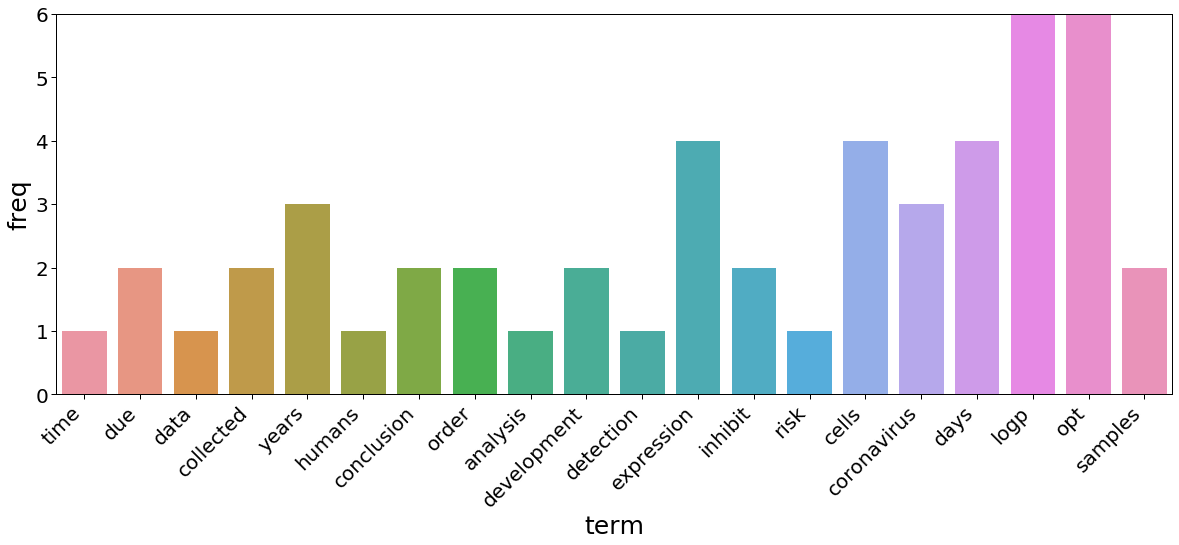

In [112]:
labelPerPeriod.createOrReplaceTempView("labelPerPeriod")

STARTING_YEAR = 2000

TOPPLOT = 20

period = str(STARTING_YEAR) + '-' + str(STARTING_YEAR+2)

labelOnePeriod = spark.sql(f"""
select term, freq
from labelPerPeriod
where period = '{period}'
order by rank
""")
# labelOnePeriod.show()

p = labelOnePeriod.toPandas()
# p.head(2)

sns.set_context("paper", rc={"axes.labelsize":25})   
plt.figure(figsize=(20,7))

# set a fixed range for the y axis
plt.ylim(0,6)

ax = sns.barplot(x="term", y="freq",  data=p[:TOPPLOT])

# size of values on axes
ax.tick_params(labelsize=20)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right');


#### Frequent terms for 2 periods

In [113]:
L = labelPerPeriod.toPandas()
L.head(10)

,period,rank,term,freq
0,2000-2002,1,time,1
1,2000-2002,2,due,2
2,2000-2002,3,data,1
3,2000-2002,4,collected,2
4,2000-2002,5,years,3
5,2000-2002,7,humans,1
6,2000-2002,8,conclusion,2
7,2000-2002,9,order,2
8,2000-2002,10,analysis,1
9,2000-2002,12,development,2


<Figure size 1440x504 with 0 Axes>

<Figure size 1440x504 with 0 Axes>

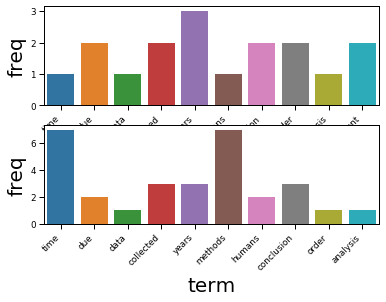

In [114]:
L1 = L[L.period=='2000-2002']
L2 = L[L.period=='2002-2004']

all = [L1, L2]

# TOPPLOT = 20


sns.set_context("paper", rc={"axes.labelsize":20})   
plt.figure(figsize=(20,7))

# set a fixed range for the y axis
plt.ylim(0,6)

# size of values on axes
ax.tick_params(labelsize=20)

plt.clf()
plt.figure(figsize=(20,7))
fig, axs = plt.subplots(2,1)
for i in range(0, 2):
    axs[i].set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right');
    sns.barplot(x="term", y="freq",  data=all[i][:10], ax=axs[i])


## Interaction

In [115]:
# interaction
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [116]:
widgets.Text("abc")

Text(value='abc')

##### Verify GUI for interaction

In [117]:
def f(x):
    return x*10

In [118]:
# from __future__ import print_function
# interact(f,x=10);
interact(f, x=widgets.IntSlider(min=-10, max=30, step=1, value=10));

100

In [119]:
out = widgets.Output(layout={'border': '1px solid black'})
with out:
    display(widgets.IntSlider())

out

IntSlider(value=0)

Output(layout=Layout(border='1px solid black'))

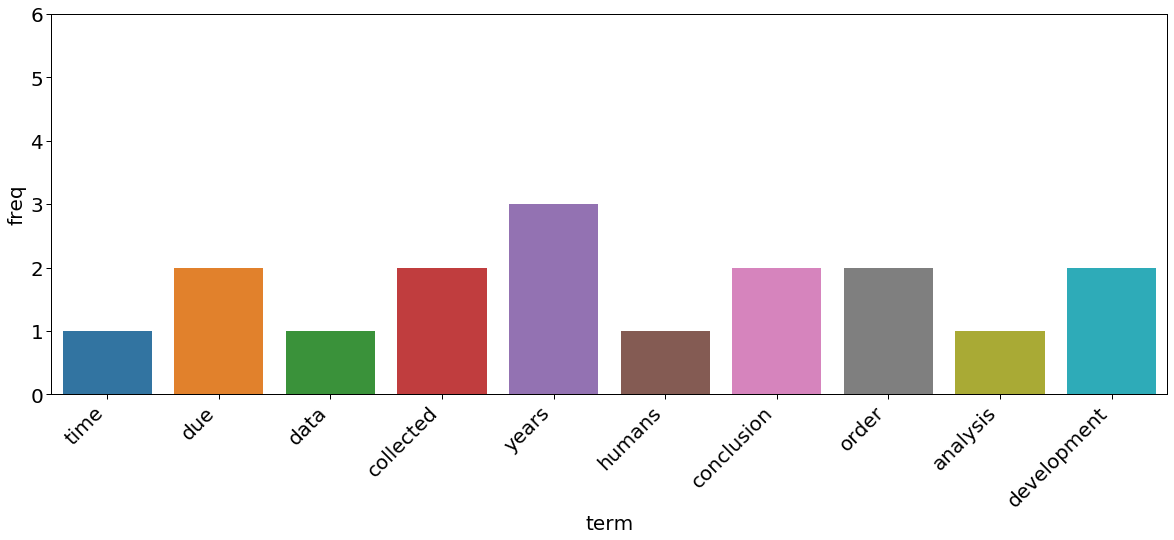

In [120]:
def plotLabelPerPeriod(startYear, topPlot):
    
    labelPerPeriod.createOrReplaceTempView("labelPerPeriod")

    period = str(startYear) + '-' + str(startYear+2)

    labelOnePeriod = spark.sql(f"""
    select term, freq
    from labelPerPeriod
    where period = '{period}'
    order by rank
    """)

    p = labelOnePeriod.toPandas()
    
    sns.set_context("paper", rc={"axes.labelsize":20})   
    plt.figure(figsize=(20,7))
    plt.ylim(0,6)
    ax = sns.barplot(x="term", y="freq",  data=p[:topPlot])
    
    # taille des valeurs sur les axes
    ax.tick_params(labelsize=20)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

    
def plotLabelPerPeriodDEBUG(startYear, topPlot):
    print(startYear)
    print(topPlot)


print("defined")
    
START_YEAR = 2002
TOPPLOT = 10

# plotLabelPerPeriod(START_YEAR, TOPPLOT)

startYearWidget= widgets.IntSlider(
    value=2000,
    min=2000,
    max=2020,
    step=2,
    description='Period:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

topPlotWidget= widgets.IntSlider(
    value=10,
    min=10,
    max=40,
    step=5,
    description='#terms',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)


# interact(plotLabelPerPeriodDEBUG, startYear=startYearWidget, topPlot=topPlotWidget);
interact(plotLabelPerPeriod, startYear=startYearWidget, topPlot=topPlotWidget);


In [121]:
period = spark.sql("""
select distinct period
from topicPeriod
order by period
""")
period.show()


+---------+
|   period|
+---------+
|2000-2002|
|2002-2004|
|2004-2006|
|2006-2008|
|2008-2010|
|2010-2012|
|2012-2014|
|2014-2016|
|2016-2018|
|2018-2020|
+---------+

